In [6]:
import matplotlib.pyplot as plt
from math import floor
from matplotlib import gridspec

"""
Problem-specific plotting
"""
class Plot:
    def __init__(self, x, y):
        plt.rcParams["figure.autolayout"] = True
        self.fig = plt.figure(figsize=(y,x))
        self.cnt = 0
        self.new_ax = None

    def add(self, y, label=None):
        if label != None:
            self.new_ax.plot(y, label=label)
            self.new_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                                 ncol = 2, fancybox=True, shadow=True,
                                 handleheight=2.4, labelspacing=0.05)
        else:
            self.new_ax.plot(y)

    def inc(self):
        """Plots the data to a new subplot at the bottom."""
        self.cnt += 1
        gs = gridspec.GridSpec(self.cnt, 1)

        # Reposition existing subplots
        for i, ax in enumerate(self.fig.axes):
            ax.set_position(gs[i].get_position(self.fig))
            ax.set_subplotspec(gs[i])

        # Add new subplot
        self.new_ax = self.fig.add_subplot(gs[self.cnt-1])
        
        
    def add_new(self, y, label="No Label"):
        self.inc()
        self.add(y, label)

    def add_new_assignment_plot(self, assignments, labels=[], fuzzy=False, length=0):
        self.inc()
        for idx, ts in enumerate(assignments):
            if not fuzzy:
                y = []
                if length == 0:
                    length = max( [ max(ts) for ts in assignments if ts != [] ] )
                for t in range(length):
                    if t in ts:
                        y.append(1)
                    else:
                        y.append(0)
            else:
                y = ts
            if max(y) > 0:
                if labels == None:
                    self.add(smoothed(y,1))
                elif labels == []:
                    self.add(smoothed(y, 1), idx)
                else:
                    self.add(smoothed(y, 1), str(labels[idx]))


    def add_new_conceptors_fit_plot(self, X, Cs, Ns=None, label="", labels=""):
        """
        Plots, for each time step t, how well each conceptor in Cs matches the state x(t)
        """
        self.inc()
        if Ns:
            collection = evidences_for_Cs(X,Cs,Ns)
        else:
            collection, _ = test(X, Cs, "PROP")
        if labels:
            for vals, label in zip(collection, labels):
                # walking average of d
                self.add(smoothed(vals, 3), label=label)
        else:                
            for i, vals in enumerate(collection):
                # walking average of d
                self.add(smoothed(vals, 3), label=label+str(i))


    def finalize(self, title=""):
        self.fig.suptitle(title, fontsize=16)
        plt.show()

In [8]:
import os, sys
import importlib
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('/Users/joris/Documents/Work/thesis/Bachelor-Thesis/Code/hierarchical-clustering/kmeans.ipynb'))))
import matplotlib.pyplot as plt
import pickle as pkl
import gc
import numpy as np
from timit.loading import Feature_Collector
from lib.conceptors import *
from lib.esn import ESN
from lib.helpers import *
import warnings
warnings.filterwarnings("ignore")

###-------------- Collecting Training Features -------------------
path = '../timit/'
fc = Feature_Collector(path)

save = True

dr = []
speakers = []
long_version = False
n_mels = 10
delta = False
delta_delta = False
subsamples = 4

path_option = str(long_version)+"_"+str(n_mels)+"_"+str(delta)+"_"+str(delta_delta)+"_"+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if speakers:
    path_option = str(speakers)+"_"+path_option
    
features,labels,oversamplings = fc.collectFeaturesInSegments(
    n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,
    subsamples=subsamples,path_option=path_option)

gc.collect()

--- Failed
4620
0


KeyboardInterrupt: 

Generating signals
K-means
epoch: 0
Computing gammas...
1  of  3
2  of  3
3  of  3
Optimal gamma:  198.99242424242425
epoch: 1
Computing gammas...
1  of  3
2  of  3
3  of  3
Optimal gamma:  122.08080808080808
Converged


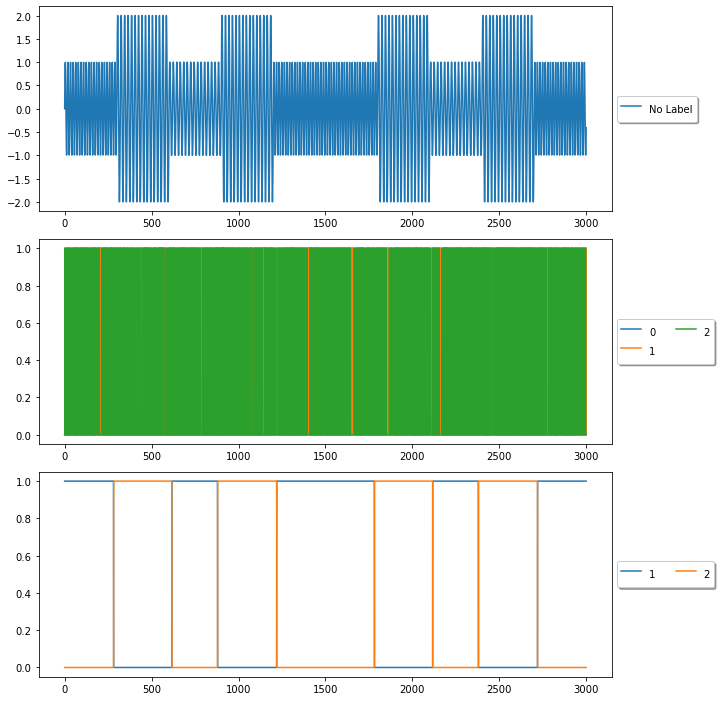

In [12]:
from enum import Enum
import numpy as np
from scipy.ndimage import gaussian_filter

from scipy import linalg
inv = linalg.inv
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('/Users/joris/Documents/Work/thesis/Bachelor-Thesis/Code/hierarchical-clustering/kmeans.ipynb'))))

#from lib.conceptors import *
from lib.esn import ESN
from lib.helpers import *
from lib.conceptors import *

plot = Plot(10,10)

########################################
# Hyperparameters

np.random.seed(0)
t_max = 300
t_washout = 0
aperture = 5

esn_params = {
    "in_dim": 1,
    "out_dim": 1,
    "N": 50,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5,
    "weights": 0.1
}

########################################
# collect data

def gen_signal(n, period, amplitude):
    """
    Generates a sin wave
    """
    ts = np.arange(n)
    data = amplitude * np.sin(2 * np.pi * (1/period) * ts)
    return data

def gen_square(n, period):
    ts = np.zeros(n)
    for t in range(n):
        ts[t] = -1+2*(t % (period * 2) < period)
    return ts

print("Generating signals")
p1 = gen_signal(t_max, 15, 1)
p2 = gen_signal(t_max, 20, 1)
p3 = gen_signal(t_max, 20, 2)
p4 = gen_square(t_max, 20)
data = [p1, p2, p3]
p = np.concatenate((p1,p3,p2,p3,p1,p1,p3,p2,p3,p1))
plot.add_new(p)
#######################################
# init reservoir

esn = ESN(esn_params)

X,_ = esn.run_X(p, t_washout, p.size)

#######################################
# Generate mixed signal

class Method(Enum):
    RANDOM = 0
    RANGES = 1
    EQUAL_SPLIT = 2

def assign_to_clusters(nb_points, nb_clusters, method=Method.EQUAL_SPLIT, limits=[]):
    """
    Assigns points to conceptors according to one of several assignment methods
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    if method == Method.RANDOM or method == Method.EQUAL_SPLIT:
        points = [ x for x in range(nb_points) ]
        if method == Method.RANDOM:
            np.random.shuffle(points)
        for i in range(nb_clusters):
            assignments[i] = points[i*int(nb_points/nb_clusters):(i+1)*int(nb_points/nb_clusters)]
    elif method == Method.RANGES:
        mark = 0
        for i in range(nb_points):
            if i in limits:
                mark += 1
            assignments[mark].append(i)
    return assignments

def assign_fuzzy_to_clusters(nb_points, nb_clusters, transition_time):
    """
    Distributes points over clusters smoothly changing float membership
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    mean_length = int(nb_points/nb_clusters)
    current = -1
    for t in range(nb_points):
        if not t % mean_length:
            current += 1
        for i in range(nb_clusters):
            if i == current:
                if t % mean_length > mean_length - transition_time and not i + 1 == nb_clusters:
                    assignments[i].append(1 - (t % mean_length - (mean_length - transition_time)) * 1 / transition_time)
                else:
                    assignments[i].append(1)
            elif i == current + 1 and t % mean_length > mean_length - transition_time:
                assignments[i].append((t % mean_length - (mean_length - transition_time)) * 1 / transition_time)
            else:
                assignments[i].append(0)
    return assignments

#######################################
# K-means
def kmeans(X, nb_conceptors, method, limits, aperture, max_epochs=100, sigma=1):
    """
    Kmeans algorithm, adapted to conceptors
    """
    print("K-means")
    # Initial assignments and initial conceptors
    nb_points = X.shape[1]
    new_assignments = assign_to_clusters(nb_points, nb_conceptors, method, limits)
    # Training loop
    for epoch in range(max_epochs):
        print("epoch:",epoch)
        # recompute centroids based on subset of assigned state
        Cs = [ compute_c(X[:,assignments], aperture) for assignments in new_assignments ]
        Cs = optimize_apertures(Cs)
        Ns = Ns_from_Cs(Cs)
        plot.add_new_assignment_plot(new_assignments, length=nb_points)
        
        # recompute assignments by find the closest conceptor for each of the state points
        old_assignments = new_assignments.copy()
        new_assignments = [ [] for _ in range(nb_conceptors) ]
        
        Es = np.zeros((nb_conceptors, nb_points))
        for t in range(nb_points):
            Es[:,t] = np.array( evidences_for_Cs_z(X[:,t], Cs, Ns) )
        
        for c in range(nb_conceptors):
            Es[c,:] = gaussian_filter(Es[c,:], order=0, sigma=sigma)
        
        for t in range(nb_points):
            conceptor_index = np.argmax(Es[:,t])
            new_assignments[ conceptor_index ].append(t)

        # stop if converged
        for new_assignment, old_assignment in zip(new_assignments, old_assignments):
            if set(new_assignment) == set(old_assignment):
                print("Converged")
                return Cs, new_assignments

    return Cs, new_assignments

#######################################

sigma = 8

Cs_kmeans, assignments_kmeans = kmeans(X, nb_conceptors=3,
                                       method=Method.RANDOM, limits=[], aperture=1, max_epochs=100, sigma=sigma)
plot.finalize()
